# Preparing Data
Instead of going over the concepts and implementations separately, let’s jump straight into the whole implementation process and elaborate on what is necessary along the way.

In order to create word embeddings, we need some sort of data. Here is a text on machine learning from Wikipedia. I’ve removed some parentheses and citation brackets to make things slightly easier.

In [1]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

# Tokenization
Since we can’t feed raw string texts into our model, we will need to preprocess this text. The first step, as is the approach taken in many NLP tasks, is to tokenize the text, i.e. splitting the text up into smaller units like words, getting rid of punctuations, and so on. Here is a function that does this trick using regular expressions.

In [2]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [3]:
tokens = tokenize(text)

Another useful operation is to create a map between tokens and indices, and vice versa. In a sense, we are creating a lookup table that allows us to easily convert from words to indices, and indices to words. This will be particularly useful later on when we perform operations such as one-hot encoding.

In [4]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word
word_to_id, id_to_word = mapping(tokens)

# Generating Training Data
Now that we have tokenized the text and created lookup tables, we can now proceed to generating the actual training data, which are going to take the form of matrices. Since tokens are still in the form of strings, we need to encode them numerically using one-hot vectorization. We also need to generate a bundle of input and target values, as this is a supervised learning technique.

This then begs the question of what the input and target values are going to look like. What is the value that we are trying to approximate, and what sort of input will we be feeding into the model to generate predictions? The answer to these questions and how they tie into word2vec is at the heart of understanding word embeddings—as you may be able to tell, word2vec is not some sort of blackbox magic, but a result of careful training with input and output values, just like any other machine learning task.

So here comes the crux of word2vec: we loop through each word (or token) in the sentence. In each loop, we look at words to the left and right of the input word, as shown below. This illustration was taken from this article by Ramzi Karam.

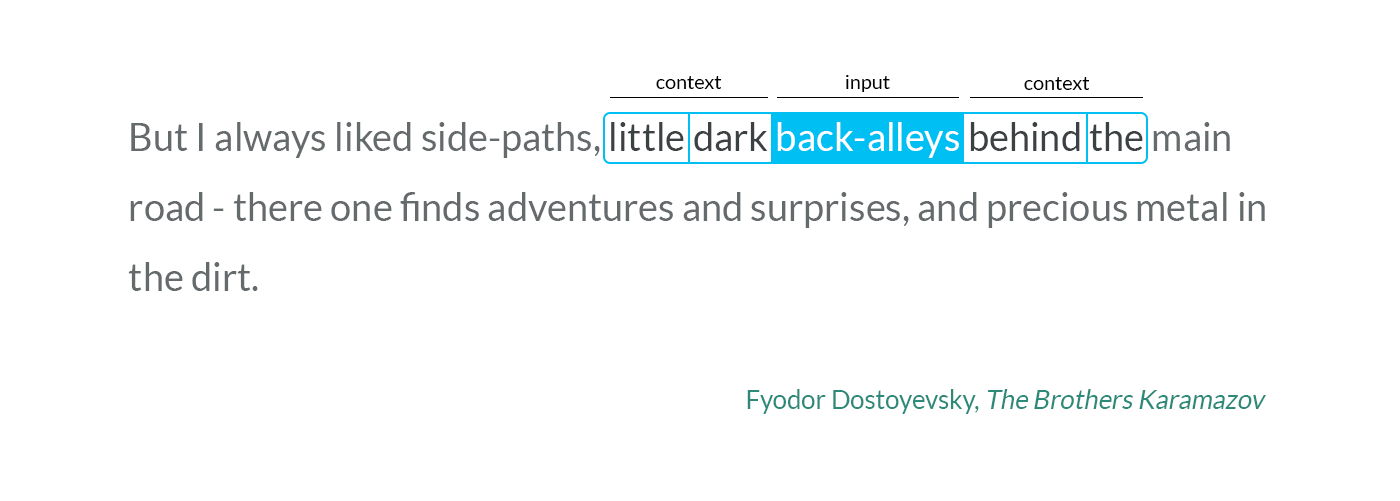

In the particular example as shown above, we would generate the following input and prediction pairs part of the training data.

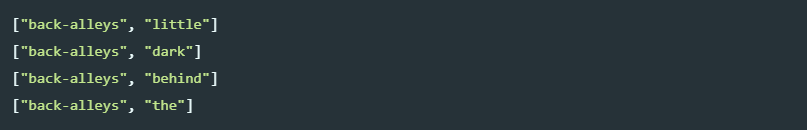

Note that the window size is two, which is why we look up to two words to the left and right of the input word. So in a way, we can understand this as forcing the model to understand a rough sense of context—the ability to see which words tend to stick together. In our own example, for instance, we would see a lot of ["machine", "learning"], meaning that the model should be able to capture the close contextual affinity between these two words.

Below is the code that generates training data using the algorithm described above. We basically iterate over the tokenized data and generate pairs. One technicality here is that, for the first and last few tokens, it may not be possible to obtain words to the left or right of that input token. In those cases, we simply don’t consider these word pairs and look at only what is feasible without causing IndexErrors. Also note that we create X and y separately instead of putting them in tuple form as demonstrated above. This is just for convenience with other matrix operations later on in the post.

In [7]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [8]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [9]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

Let’s quickly check the dimensionality of the data to get a sense of what matrices we are working with. This intuition will become important in particular when training and writing equations for backpropagation in the next section.

In [10]:
X, y = generate_training_data(tokens, word_to_id, 2)


In [11]:
X.shape, y.shape

((330, 60), (330, 60))

Both X and y are matrices with 330 rows and 60 columns. Here, 330 is the number of training examples we have. We would expect this number to have been larger had we used a larger window. 60 is the size of our corpus, or the number of unique tokens we have in the original text. Since we have one-hot encoded both the input and output as 60-dimensional sparse vectors, this is expected.

Now, we are finally ready to build and train our embedding network.

# The Embedding Model
At this point, you might be wondering how it is that training a neural network that predicts some nearby context word given an input token can be used to embed words into vectors. After all, the output of the network is going to be some probability vector that passed through a softmax layer, not an embedding vector.

This is entirely correct, and this is a question that came to my mind as well. However, this is the part that gets the most interesting: the rows of the intermediate weight matrix is the embedding we are looking for! This becomes much more apparent once we consider the dimensions of the weight matrices that compose the model. For simplicity purposes, say we have a total of 5 words in the corpus, and that we want to embed these words as three-dimensional vectors.

More specifically, here is the first weight layer of the model:

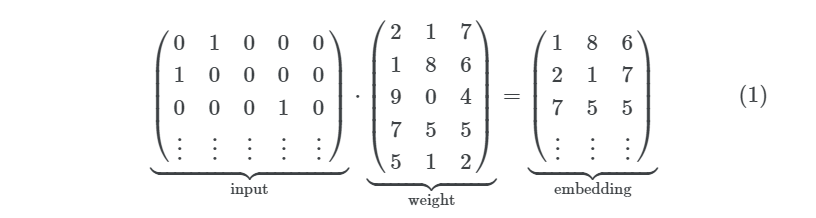

A crucial observation to make is that, because the input is a sparse vector containing one-hot encoded vectors, the weight matrix effectively acts as a lookup table that moves one-hot encoded vectors to dense vectors in a different dimension—more precisely, the row space of the weight matrix. In this particular example, the weight matrix was a transformation of



. This is exactly what we want to achieve with embedding: representing words as dense vectors, a step-up from simple one-hot encoding. This process is exactly what embedding is: as we start training this model with the training data generated above, we would expect the row space of this weight matrix to encode meaningful semantic information from the training data.

Continuing onwards, here is the second layer that receives as input the embeddings, then uses them to generate a set of outputs:

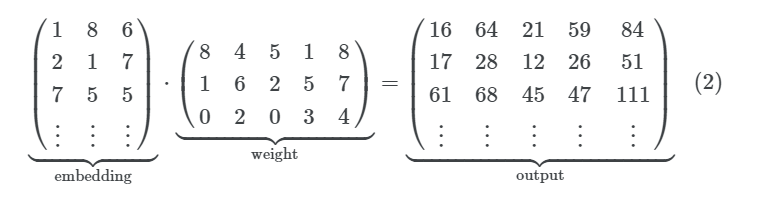

We are almost done. All we now need in the last layer is a softmax layer. When the output is passed into this layer, it is converted into probability vectors whose elements sum up to one. This final output can be considered as context predictions, i.e. which words are likely to be in the window vicinity of the input word.

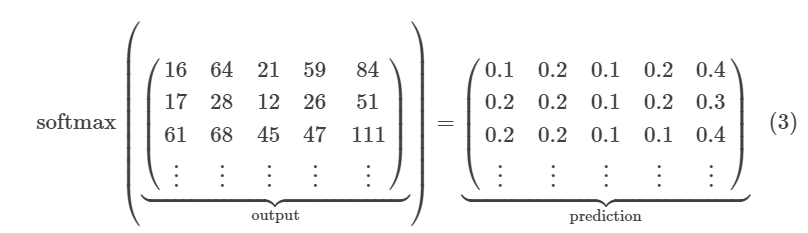

In training—specifically error calculation and backpropagation—we would be comparing this prediction of probability vectors with its true one-hot encoded targets. The error function that we use with softmax is cross entropy, defined as

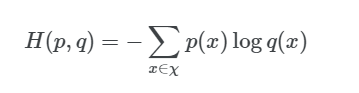

I like to think of this as a dot product of the target vector and the log of the prediction, because that is essentially what the summation is doing. In this alternate formulation, the cross entropy formula can be rewritten as

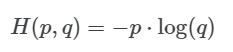

Because p a one-hot encoded vector in this case, all the elements in p whose entry is zero will have no effect on the final outcome. Indeed, we simply end up taking the negative log of the prediction. Notice that the closer the value of the prediction is to 1, the smaller the cross entropy, and vice versa. This aligns with the behavior we want, since we want the predicted probability to be as close to 1 as possible.

So let’s summarize the entire process a little bit. First, embeddings are simply the rows of the first weight matrix, denoted as W1
. Through training and backpropgation, we adjust the weights of W1
, along with the weight matrix in the second layer, denoted as W2
, using cross entropy loss. Overall, our model takes on the following structure:

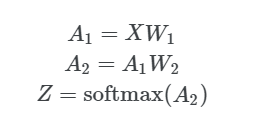


# Code Implementation
Let’s start implement this model in code. The implementation we took here is extremely similar to the approach we took in this post. For an in-depth review of backpropagation derivation with matrix calculus, I highly recommend that you check out the linked post.

The representation we will use for the model is a Python dictionary, whose values are the weight matrices and keys, the name with which we will refer to the weight matrices. In accordance with the nomenclature established earlier, we stick with "w1" and "w2" to refer to these weights.

In [12]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

Let’s specify our model to create ten-dimensional embeddings. In other words, each token will be represented as vectors living in ten-dimensional space. Note that actual models tend to use much higher dimensions, most commonly 300, but for our purposes this is not necessary.

In [13]:
model = init_network(len(word_to_id), 10)

# Forward Propagation
Let’s begin with forward propagation. Coding the forward propagation process simply amounts to transcribing the three matrix multiplication equations in into NumPy code.

In [14]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

For backpropagation, we will need all the intermediate variables, so we hold them in a dictionary called cache. However, if we simply want the final prediction vectors only, not the cache, we set return_cache to False. This is just a little auxiliary feature to make things slightly easier later.

We also have to implement the softmax() function we used above. Note that this function receives a matrix as input, not a vector, so we will need to slightly tune things up a bit using a simple loop.

In [15]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

At this point, we are done with implementing the forward pass. However, before we move on, it’s always a good idea to check the dimensionality of the matrices, as this will provide us with some useful intuition while coding backward propagation later on.

The dimensionality of the matrix after passing the first layer, or the embedding layer, is as follows:

In [16]:
(X @ model["w1"]).shape

(330, 10)

This is expected, since we want all the 330 tokens in the text to be converted into ten-dimensional vectors.

Next, let’s check the dimensionality after passing through the second layer. This time, it is a 330-by-60 matrix. This also makes sense, since we want the output to be sixty dimensional, back to the original dimensions following one-hot encoding. This result can then be passed onto the softmax layer, the result of which will be a bunch probability vectors.

In [17]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

# Backpropagation
Implementing backward propagation is slightly more difficult than forward propagation. However, the good news is that we have already derived the equation for backpropagation given a softmax layer with cross entropy loss in this post, where we built a neural network from scratch. The conclusion of the lengthy derivation was ultimately that

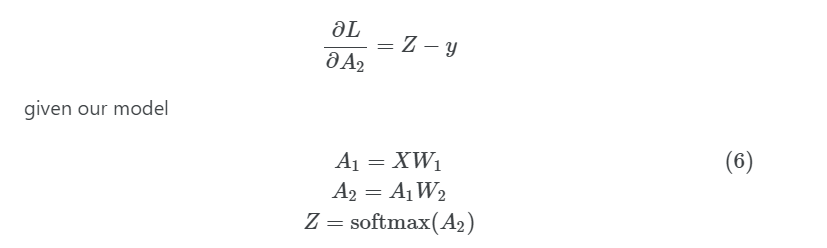

Since we know the error, we can now backpropagate it throughout the entire network, recalling basic principles of matrix calculus. If backprop is still confusing to you due to all the tranposes going on, one pro-tip is to think in terms of dimensions. After all, the dimension of the gradient must equal to the dimension of the original matrix. With that in mind, let’s implement the backpropagation function.

In [18]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

To keep a log of the value of the error throughout the backpropagation process, I decided to make the final return value of backward() to be the cross entropy loss between the prediction and the target labels. The cross entropy loss function can easily be implemented as follows.

In [19]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

# Testing the Model
As we only have a small number of training data—coupled with the fact that the backpropagation algorithm is simple batch gradient descent—let’s just iterate for 50 epochs. While training, we will be caching the value of the cross entropy error function in a history list. We can then plot this result to get a better sense of whether the training worked properly.

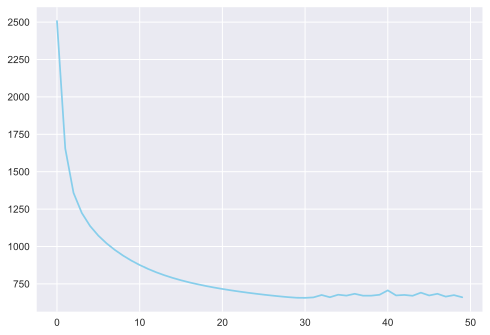

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

And indeed it seems like we did well! We can thus say with some degree of confidence that the embedding layer has been trained as well.

An obvious sanity check we can perform is to see which token our model predicts given the word “learning.” If the model was trained properly, the most likely word should understandably be “machine.” And indeed, when that is the result we get: notice that “machine” is at the top of the list of tokens, sorted by degree of affinity with “learning.”

In [21]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
intelligence
is
are
the
so
build
needed
where
algorithms
study
computer
subset
artificial
a
programmed
of
that
wide
seen
conventional
vision
order
to
decisions
infeasible
and
used
difficult
mathematical
through
develop
learning
variety
or
experience
predictions
explicitly
tasks
perform
it
improve
training
do
make
applications
model
filtering
being
automatically
email
without
in
such
sample
on
known
based
as
data
